In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

In [48]:
model = VGG16(include_top=False, input_shape=(150, 150, 3))

In [49]:
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

In [50]:
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [51]:
train_dir ='/content/drive/MyDrive/Colab Notebooks/intel-image-classification/seg_train/seg_train'
valid_dir ='/content/drive/MyDrive/Colab Notebooks/intel-image-classification/seg_test/seg_test'
pred_dir  = '/content/drive/MyDrive/Colab Notebooks/intel-image-classification/seg_pred'

In [ ]:
rescale = 1./255,
	    rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.01,
      zoom_range=[0.1, 1.5],
      horizontal_flip=True,
      fill_mode='nearest',
      zca_whitening=True,
      brightness_range=[0.1, 2]

In [52]:
#train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=15, horizontal_flip=True, fill_mode='nearest', brightness_range=[0.1, 2])
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=15, horizontal_flip=True, brightness_range=[0.1, 2])

train_generator=train_datagen.flow_from_directory(
      train_dir,
      target_size=(150,150),
      batch_size=64,
      class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator=valid_datagen.flow_from_directory(
      valid_dir,
      target_size=(150,150),
      batch_size=64,
      class_mode='categorical')

test_datagen = ImageDataGenerator(rescale = 1./255,  rotation_range=15, horizontal_flip=True, brightness_range=[0.1, 2])
test_generator = test_datagen.flow_from_directory(
    pred_dir, 
    target_size=(150,150),
    batch_size=32,
    class_mode = 'categorical' ) 

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 6 classes.


In [53]:
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['accuracy'])

In [54]:
H = model.fit(train_generator, batch_size=128,
              epochs=10, 
              validation_data=validation_generator)

Epoch 1/10
220/220 [==============================] - 119s 536ms/step - loss: 0.8243 - accuracy: 0.6780 - val_loss: 0.4131 - val_accuracy: 0.8530
Epoch 2/10
220/220 [==============================] - 115s 523ms/step - loss: 0.3421 - accuracy: 0.8790 - val_loss: 0.2521 - val_accuracy: 0.9087
Epoch 3/10
220/220 [==============================] - 115s 524ms/step - loss: 0.2487 - accuracy: 0.9113 - val_loss: 0.2349 - val_accuracy: 0.9133
Epoch 4/10
220/220 [==============================] - 115s 522ms/step - loss: 0.2193 - accuracy: 0.9241 - val_loss: 0.2092 - val_accuracy: 0.9243
Epoch 5/10
220/220 [==============================] - 115s 523ms/step - loss: 0.1968 - accuracy: 0.9312 - val_loss: 0.2316 - val_accuracy: 0.9177
Epoch 6/10
220/220 [==============================] - 115s 522ms/step - loss: 0.1868 - accuracy: 0.9348 - val_loss: 0.2127 - val_accuracy: 0.9203
Epoch 7/10
220/220 [==============================] - 115s 521ms/step - loss: 0.1667 - accuracy: 0.9408 - val_loss: 0.2038 -

In [58]:
# save the model's trained weights 
model.save_weights('vgg_transfer_trained_wts.h5')

In [55]:
score = model.evaluate(test_generator)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

229/229 [==============================] - 51s 224ms/step - loss: 0.3417 - accuracy: 0.8996
Test Loss =  0.3416937291622162
Test Accuracy =  0.8996027708053589


In [56]:
# Making prediction
y_pred = model.predict(test_generator)
y_true = np.argmax(y_pred, axis=-1)
 
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
confusion_mtx

array([[1107,    0,    0,    0,    0,    0],
       [   0, 1164,    0,    0,    0,    0],
       [   0,    0, 1115,    0,    0,    0],
       [   0,    0,    0, 1442,    0,    0],
       [   0,    0,    0,    0, 1146,    0],
       [   0,    0,    0,    0,    0, 1327]])

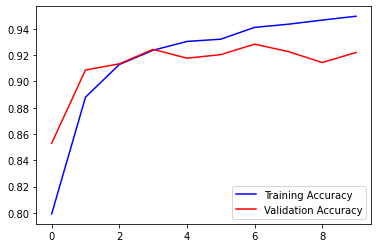

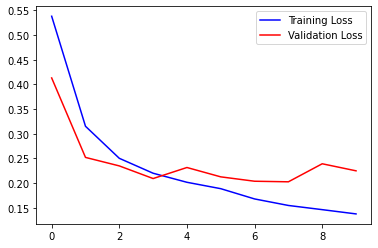

In [57]:
acc=H.history['accuracy']
val_acc=H.history['val_accuracy']
loss=H.history['loss']
val_loss=H.history['val_loss']
 
epochs=range(len(acc)) 
 
#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()
 
#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()